<a href="https://colab.research.google.com/github/OlgaTora/Wine-dataset/blob/main/Wine_dataset_AgeevaOO_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and description of dataset



In [1]:
from plotly import express
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error
import math
from sklearn import preprocessing

pd.set_option('display.max_columns',100) 
pd.set_option('display.max_rows',100)

red = pd.read_csv('/content/drive/MyDrive/wine/Red.csv')
rose = pd.read_csv('/content/drive/MyDrive/wine/Rose.csv')
sparkling = pd.read_csv('/content/drive/MyDrive/wine/Sparkling.csv')
varieties = pd.read_csv('/content/drive/MyDrive/wine/Varieties.csv')
white = pd.read_csv('/content/drive/MyDrive/wine/White.csv')

red['type_wine'] = 'red'
white['type_wine'] = 'white'
sparkling['type_wine'] = 'sparkling'
rose['type_wine'] = 'rose'
wine =  pd.concat([red, white, sparkling, rose], ignore_index=True)

# EDA

In [2]:
wine.tail()

,Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year,type_wine
13829,Côte des Roses Rosé 2019,France,Languedoc,Gérard Bertrand,3.9,1750,9.36,2019,rose
13830,M Rosé 2019,France,Côtes de Provence,Minuty,4.0,2046,12.85,2019,rose
13831,Whispering Angel Rosé 2019,France,Côtes de Provence,Château d'Esclans,4.2,2990,16.47,2019,rose
13832,Vinho Verde Rosé N.V.,Portugal,Vinho Verde,Casal Garcia,3.5,9493,4.35,N.V.,rose
13833,The Original Rosé N.V.,Portugal,Douro,Mateus,3.6,29531,5.99,N.V.,rose


In [3]:
wine.shape

(13834, 9)

In [4]:
# проверка пропущенных значений
wine.isna().sum()

Name               0
Country            0
Region             0
Winery             0
Rating             0
NumberOfRatings    0
Price              0
Year               0
type_wine          0
dtype: int64

In [5]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13834 entries, 0 to 13833
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             13834 non-null  object 
 1   Country          13834 non-null  object 
 2   Region           13834 non-null  object 
 3   Winery           13834 non-null  object 
 4   Rating           13834 non-null  float64
 5   NumberOfRatings  13834 non-null  int64  
 6   Price            13834 non-null  float64
 7   Year             13834 non-null  object 
 8   type_wine        13834 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 972.8+ KB


У вина не всегда есть винтаж, нужно заменить значение.

In [6]:
# изменим тип данных у года
# отсутствие года меняем на год, например, на 2023. Так как год важен для вина

wine['Year'] = wine['Year'].replace('N.V.', 2023)
wine['Year'] = wine['Year'].astype(np.int64)

In [7]:
# выделим количественные и качественные признаки в отдельные группы
num_features = wine[['Price', 'NumberOfRatings', 'Year']]

In [8]:
# проверка на дубликаты строк
wine.loc[wine.duplicated()]

,Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year,type_wine


In [9]:
wine.describe()

,Rating,NumberOfRatings,Price,Year
count,13834.000000,13834.000000,13834.000000,13834.000000
mean,3.865664,428.322466,33.024850,2015.933425
std,0.296427,1838.413812,70.899893,3.605037
min,2.200000,25.000000,3.150000,1961.000000
25%,3.700000,56.000000,9.902500,2015.000000
50%,3.900000,129.000000,15.950000,2016.000000
75%,4.100000,336.000000,32.500000,2018.000000
max,4.900000,94287.000000,3410.790000,2023.000000


Разброс между максимумом и 75 квантилем большой, но есть великие вина, у которых действительно отрыв в цене и качестве будет. Также есть популярные вина, как шампань Моет или Клико.
Аномалии составляют порядка 25% от датасета.
Оставим для исследования оба варианта.

In [10]:
Q1 = wine.quantile(0.25)
Q3 = wine.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

# Код с удалением нужно ввести после подгототвки данных к работе
# wine_no_anomalies = wine[~((wine<(Q1 - 1.5 * IQR))|(wine>(Q3 + 1.5 * IQR))).any(axis= 1)]

Rating               0.4000
NumberOfRatings    280.0000
Price               22.5975
Year                 3.0000
dtype: float64


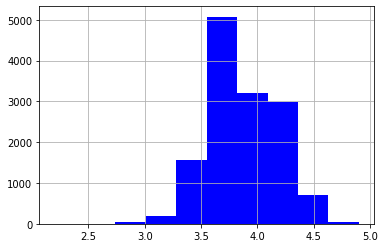

In [11]:
# Посмотрим графически на целевой признак:
wine['Rating'].hist(color='blue')

Видно, что рейтинг располагается в промеждутке от 2,5 до 4,9 баллов.

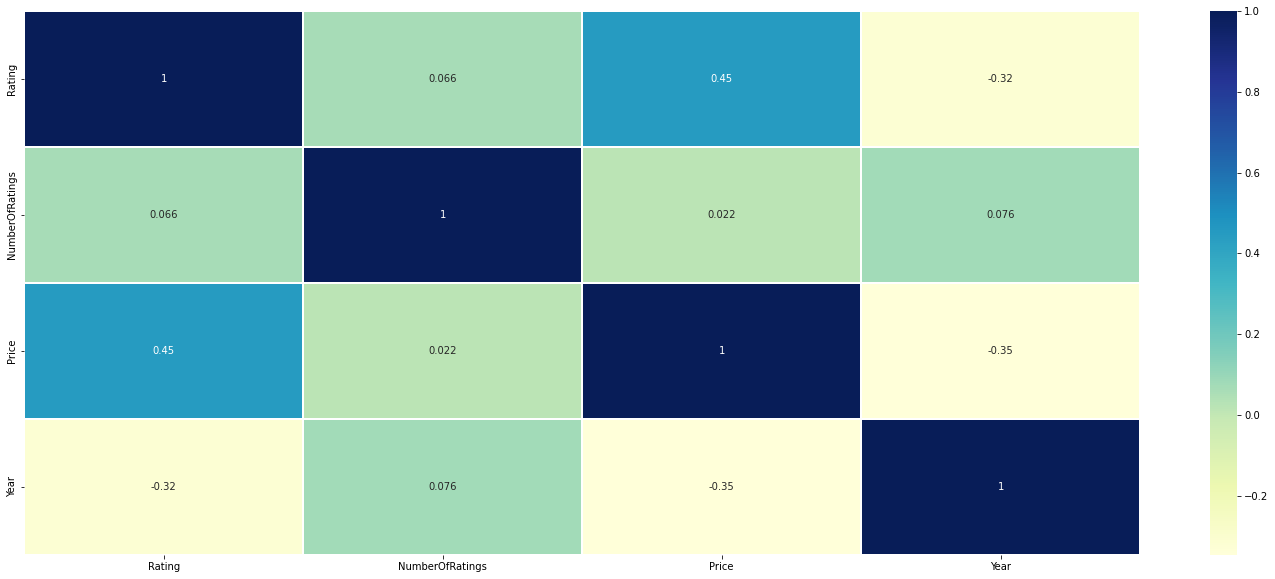

In [12]:
fig = plt.subplots(ncols=1, figsize=(25,10))
sns.heatmap(wine.corr(), annot = True, linewidths=0.8, cmap = 'YlGnBu')

Корреляция продаж и количества единиц

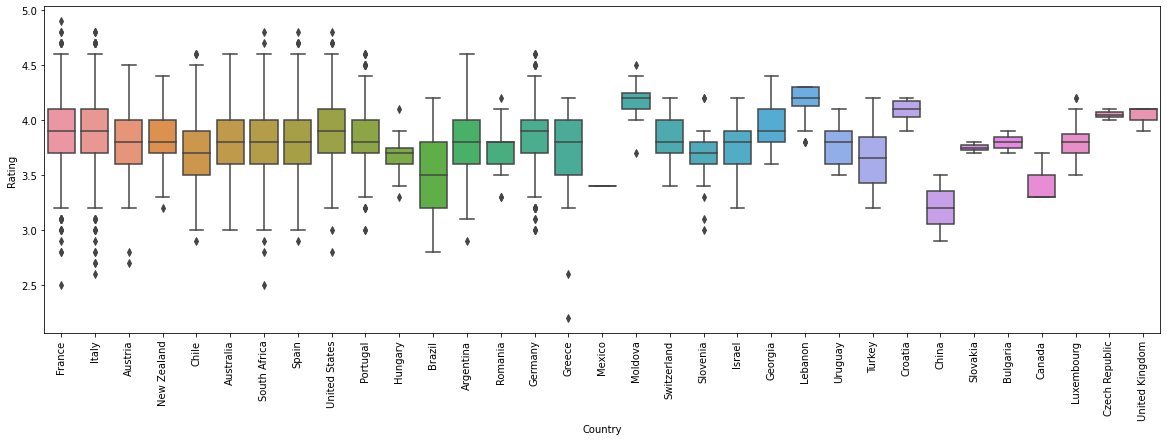

In [13]:
fig, ax = plt.subplots(ncols=1, figsize=(20,6))
sns.boxplot(x='Country', y='Rating', data=wine, ax=ax)
plt.xticks(rotation=90)
plt.show()

Зависимость рейтинга от числовых признаков - невысокая.
Надо отметить, что большая часть оцененных вин находится в недорогом сегменте (до 500 евро) и более свежих винтажей. Это объясняется тем, что продажи в бутылках по винам на каждый день в несколько раз выше, чем вин великих. 

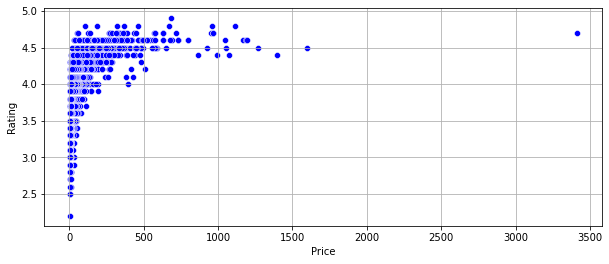

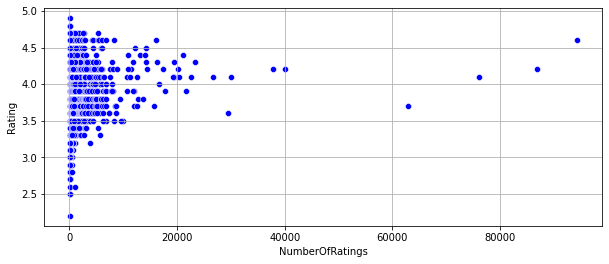

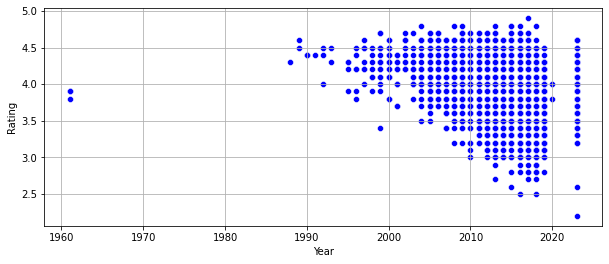

In [14]:
#sns.set_style("darkgrid")
for feature in num_features:
  plt.figure(figsize = (10,4))
  sns.scatterplot(data = wine, y= 'Rating', x= num_features[feature], color='blue')
  plt.grid()

Text(0.5, 0, 'Region')

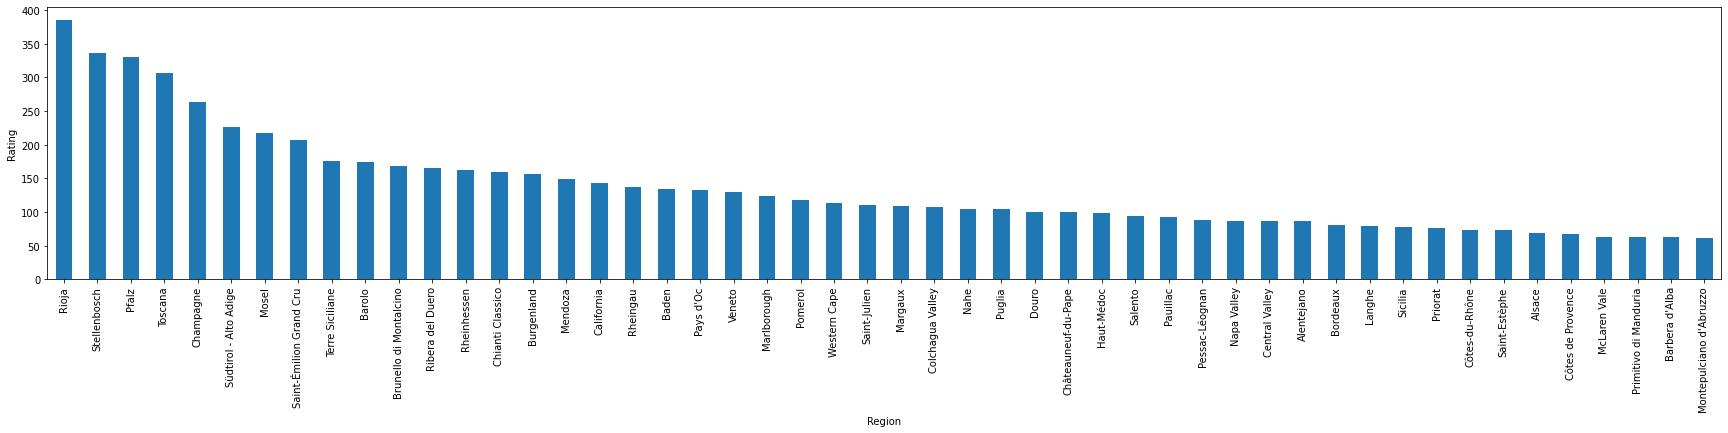

In [15]:
wine.Region.value_counts().nlargest(50).plot(kind='bar', figsize=(30,5))
plt.ylabel('Rating')
plt.xlabel('Region')

Text(0.5, 0, 'Country')

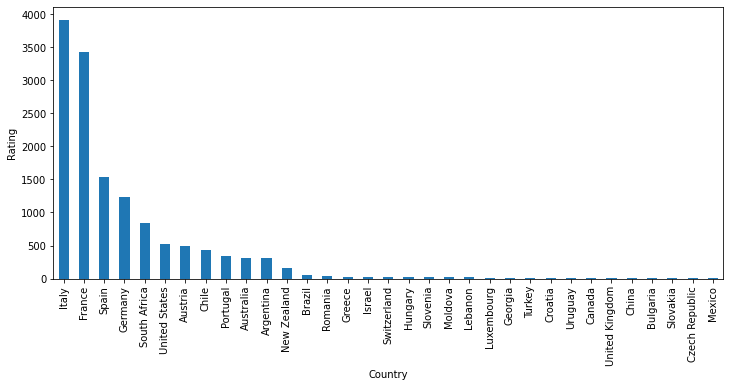

In [16]:
wine.Country.value_counts().nlargest(33).plot(kind='bar', figsize=(12,5))
plt.ylabel('Rating')
plt.xlabel('Country')

Вина из популярных регионов оценивают гораздо чаще, и покупают их чаще. По самим производителям такой яркой выраженности нет, но в первые 35 виноделен попадают достаточно известные производители.

Text(0.5, 0, 'Winery')

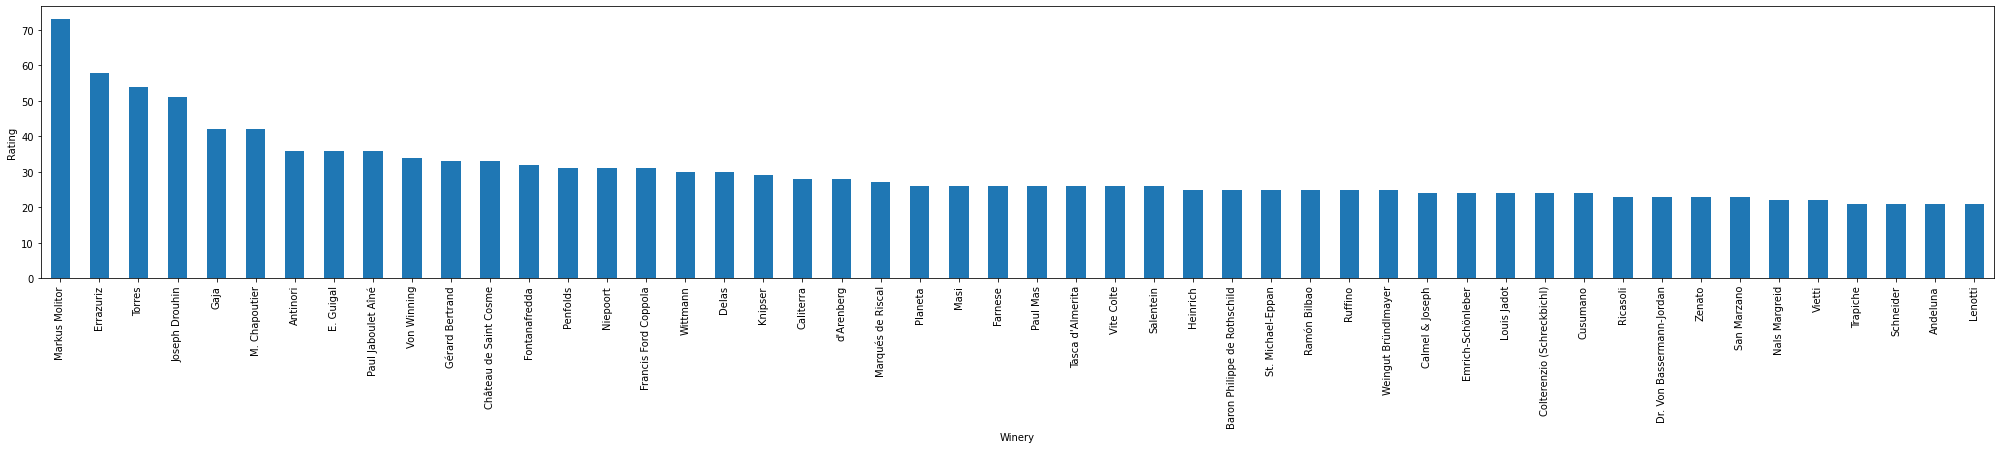

In [17]:
wine.Winery.value_counts().nlargest(50).plot(kind='bar', figsize=(35,5))
plt.ylabel('Rating')
plt.xlabel('Winery')

Зависимость рейтинга от типа вина. Согласно графику мы видим, что вбросы есть у красного и белого вина, их в принципе употребляют больше, чем игристого и розового вина. Но рейтинги выше по красному и игристому.  

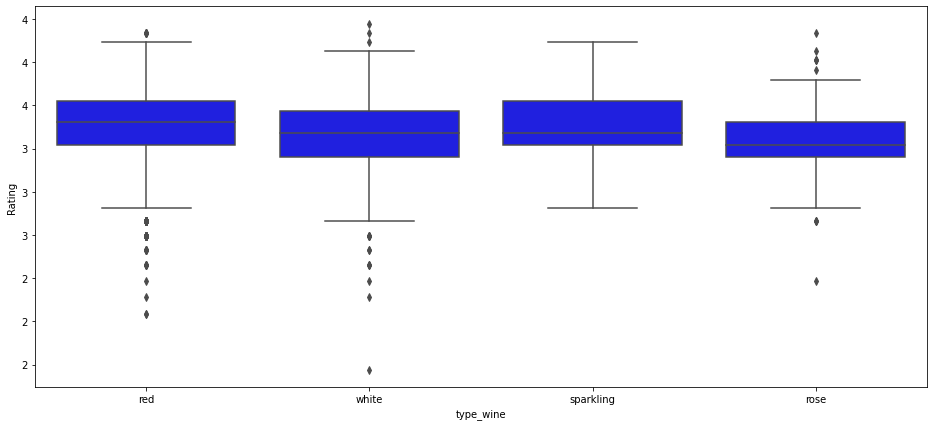

In [18]:
plt.figure(figsize=(16,7))

graphic = sns.boxplot(x='type_wine', y=np.log(wine['Rating']), data=wine, color='blue')
graphic.set_xticklabels(graphic.get_xticklabels())
graphic.set_yticklabels(np.exp(graphic.get_yticks()).astype(int))

plt.show()

Округлим цену до целого значения и проверим количество уникальных значений в этом случае, также переведем цену в int.

In [19]:
# Округление года вызывает еще большую корреляцию с рейтингом.
# wine['Price'] = (round(wine['Price'], 0)).astype(np.int64)


In [20]:
wine['Price'].sort_values()

12691       3.15
12530       3.15
5423        3.55
13816       3.67
2938        3.70
          ...   
4124     1197.90
4395     1266.25
5560     1399.00
7466     1599.95
2344     3410.79
Name: Price, Length: 13834, dtype: float64

In [21]:
# Удалим строку с очень высокой ценой, она такая одна и с ней неудобно анализировать график
wine = wine.loc[wine['Price'] != 3410.79]
wine.shape

(13833, 9)

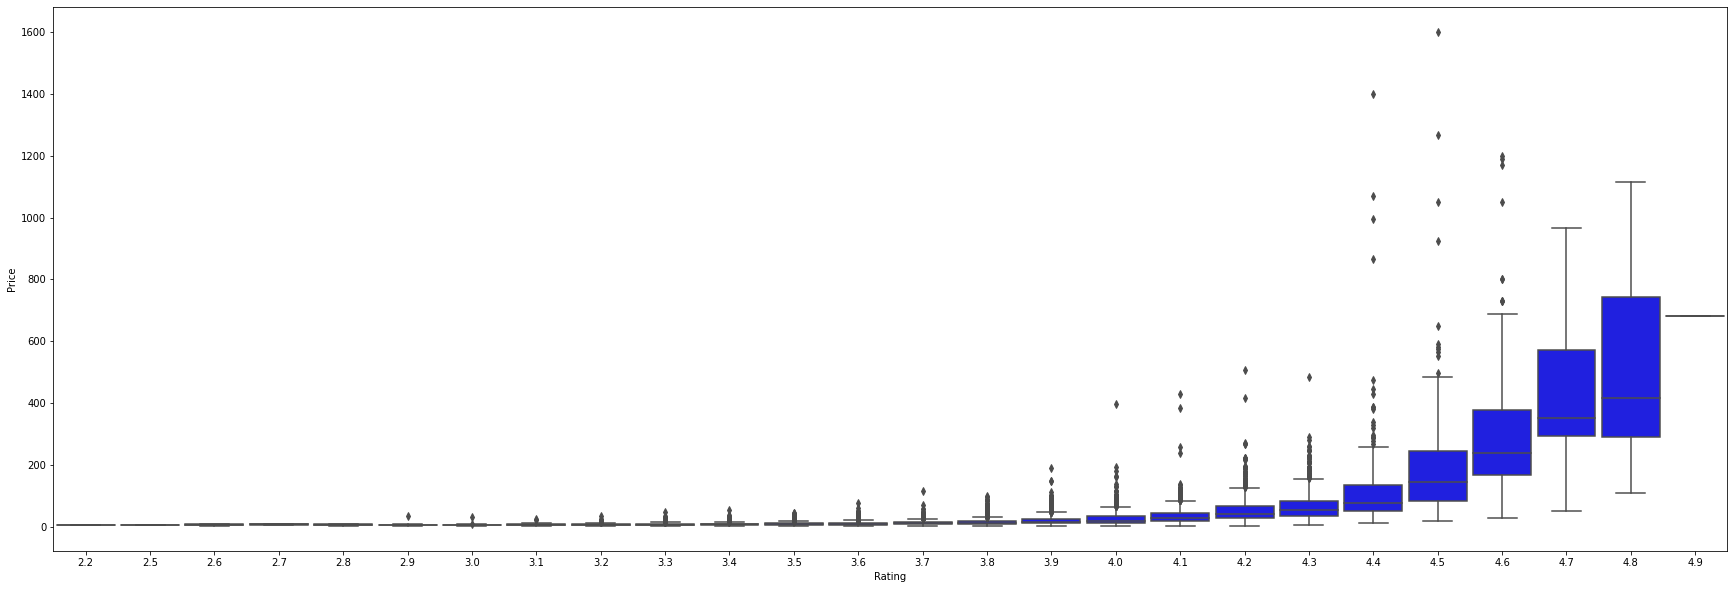

In [22]:
plt.figure(figsize = (30,10))
sns.boxplot(data = wine, x= 'Rating', y= 'Price', color='blue', width= 0.9)

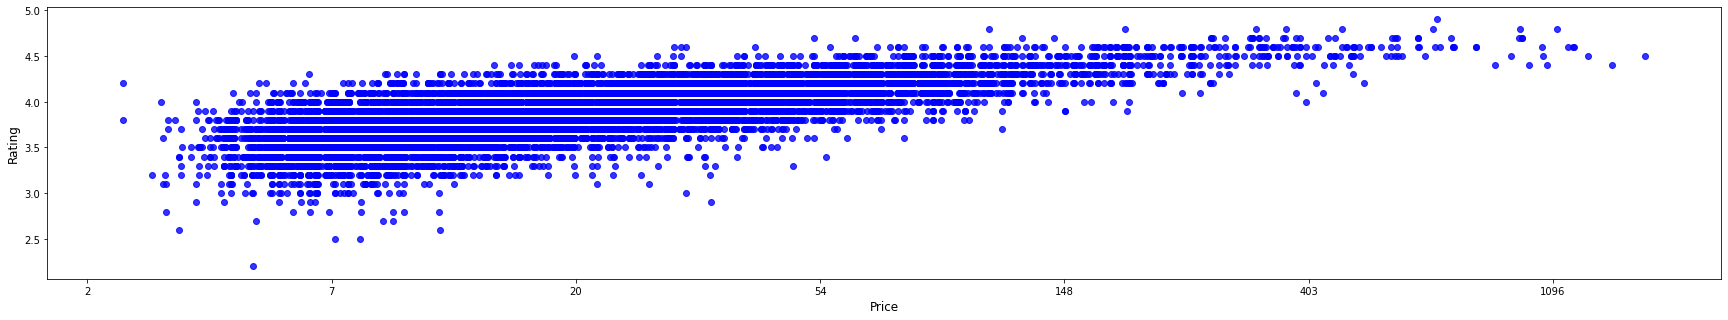

In [23]:
plt.figure(figsize=(30,5))
graph = sns.regplot(x=np.log(wine['Price']), y='Rating', data=wine, fit_reg=False, color='blue')
graph.set_xlabel("Price", fontsize= 12)
graph.set_ylabel("Rating", fontsize= 12)
graph.set_xticklabels(np.exp(graph.get_xticks()).astype(int))

plt.show()

По имеющейся информации данную задачу можно свести к регрессии - прогнозу рейтинга на вино, по которому не давали оценки пользователи.
Также ее можно свести к классификации: распределить рейтинг на 4 категории.
В приложении vivino используются численные оценки, а не категории, поэтому реализуем задачу регрессии. Из признаков есть зависимость с ценой, это видно на последних графиках.

# Feature engeeniring


In [24]:
wine['Variety'] = np.nan

In [25]:
# Наименований вин очень много, и в ряди из них упоминается сорт винограда (это действительно так)
#Добавим колонку с сортом с тех позициях, где есть сорт в названии

for index in wine.index:
    for variety in varieties['Variety']:    
        if variety in wine.loc[index, 'Name']:
            wine.loc[index, 'Variety'] = variety
            break

In [26]:
#Где сорт не указан, напишем blend
wine.Variety = wine.Variety.fillna('blend')
wine.Variety.value_counts().head(20)

blend                 8065
Riesling               699
Chardonnay             558
Cabernet Sauvignon     557
Sauvignon Blanc        357
Merlot                 275
Pinot Noir             271
Shiraz                 234
Brunello               172
Syrah                  172
Malbec                 163
Primitivo              123
Prosecco               120
Barbera                119
Tempranillo            117
Montepulciano          108
Grüner Veltliner        93
Pinot Grigio            91
Pinotage                80
Zinfandel               67
Name: Variety, dtype: int64

Посмотрим количество уникальных значений. Их много в названии вина, регионе, винодельне, цене и количестве голосов.

In [27]:
wine.nunique()

Name               10934
Country               33
Region               861
Winery              3504
Rating                26
NumberOfRatings     1821
Price               3007
Year                  34
type_wine              4
Variety              209
dtype: int64

Посмотрим на страны производители. В датасете их 33, но некоторые представлены менее 0,5%. Заменим их на "другие страны"

In [28]:
wine.Country.value_counts()[12:]

Brazil            50
Romania           37
Greece            25
Switzerland       23
Israel            23
Hungary           19
Slovenia          18
Moldova           16
Lebanon           16
Luxembourg        14
Georgia           13
Turkey            10
Croatia            6
Uruguay            5
Canada             3
United Kingdom     3
China              3
Bulgaria           2
Slovakia           2
Czech Republic     2
Mexico             1
Name: Country, dtype: int64

In [29]:
wine['Country'] = wine['Country'].replace('Brazil', 'Other Countries')
wine['Country'] = wine['Country'].replace('Greece', 'Other Countries')
wine['Country'] = wine['Country'].replace('Romania', 'Other Countries')
wine['Country'] = wine['Country'].replace('Switzerland', 'Other Countries')
wine['Country'] = wine['Country'].replace('Israel', 'Other Countries')
wine['Country'] = wine['Country'].replace('Hungary', 'Other Countries')
wine['Country'] = wine['Country'].replace('Slovenia', 'Other Countries')
wine['Country'] = wine['Country'].replace('Moldova' , 'Other Countries')
wine['Country'] = wine['Country'].replace('Lebanon' , 'Other Countries')
wine['Country'] = wine['Country'].replace('Georgia' , 'Other Countries')
wine['Country'] = wine['Country'].replace('Turkey' , 'Other Countries')
wine['Country'] = wine['Country'].replace('Croatia' , 'Other Countries')
wine['Country'] = wine['Country'].replace('Uruguay' , 'Other Countries')
wine['Country'] = wine['Country'].replace('China' , 'Other Countries')
wine['Country'] = wine['Country'].replace('Slovakia' , 'Other Countries')
wine['Country'] = wine['Country'].replace('Mexico' , 'Other Countries')
wine['Country'] = wine['Country'].replace('Bulgaria' , 'Other Countries')
wine['Country'] = wine['Country'].replace('Canada' , 'Other Countries')
wine['Country'] = wine['Country'].replace('Luxembourg' , 'Other Countries')
wine['Country'] = wine['Country'].replace('Czech Republic' , 'Other Countries')
wine['Country'] = wine['Country'].replace('United Kingdom' , 'Other Countries')
wine.Country.value_counts()

Italy              3919
France             3435
Spain              1533
Germany            1229
South Africa        846
United States       530
Austria             492
Chile               431
Portugal            336
Australia           318
Argentina           308
Other Countries     291
New Zealand         165
Name: Country, dtype: int64

В других странах проставим другой регион и другая винодельня. Таких значений 2,5% от датасета. Их можно и удалить, но при большом размере датасета таких вин и стран может быть и больше.

In [30]:
for index in wine.index:  
  if wine.loc[index, 'Country'] == 'Other Countries':
    wine.loc[index, 'Region'] = 'Other Region'
    wine.loc[index, 'Winery'] = 'Other Winery' 
  

In [31]:
# Если переводитб цены в категории, то корреляция еще больше увеличиться, проверено
# wine.loc[(wine.Price > 300), 'Price'] = -1
# wine.loc[(wine.Price > 100), 'Price'] = -2
# wine.loc[(wine.Price > 50), 'Price'] = -3
# wine.loc[(wine.Price > 20), 'Price'] = -4
# wine.loc[(wine.Price > 10), 'Price'] = -5
# wine.loc[(wine.Price > 0), 'Price'] = -6

In [32]:
wine.nunique()

Name               10934
Country               13
Region               792
Winery              3421
Rating                26
NumberOfRatings     1821
Price               3007
Year                  34
type_wine              4
Variety              209
dtype: int64

Теперь можно удалить название вина, так как почти весь датасет это значения уникальные. Также удалим название винодельни, тк очень много значений уникальных (одна треть от датасета)

In [33]:
#Столбец с типом вина преобразуем в несколько столбцов для работы в sklearn, тк этот признак содержит всего 4 варианта
wine = pd.get_dummies(wine, columns = ['type_wine'])

In [34]:
wine = wine.drop(columns = ['Name', 'Winery'])

In [35]:
# Сделаем копию для автоматических библиотек
wine_for_autoML = wine.copy()
wine_for_autoML.to_csv('/content/drive/MyDrive/Wine_for_autoML.csv')

**Caterogial features**

Для работы необходимо преобразовать категориальные признаки в числовые.

In [36]:
cat_feat = wine.select_dtypes(include='object')
cat_feat.describe()

,Country,Region,Variety
count,13833,13833,13833
unique,13,792,209
top,Italy,Rioja,blend
freq,3919,385,8065


In [37]:
from sklearn import preprocessing
for columns in cat_feat:
  encoder = preprocessing.LabelEncoder()
  encoder = encoder.fit(wine[columns])
  wine[columns] = encoder.transform(wine[columns])

In [38]:
wine.head(3)

,Country,Region,Rating,NumberOfRatings,Price,Year,Variety,type_wine_red,type_wine_rose,type_wine_sparkling,type_wine_white
0,4,535,4.2,100,95.00,2011,208,1,0,0,0
1,4,382,4.3,100,15.50,2017,208,1,0,0,0
2,6,690,3.9,100,7.45,2015,208,1,0,0,0


In [39]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13833 entries, 0 to 13833
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country              13833 non-null  int64  
 1   Region               13833 non-null  int64  
 2   Rating               13833 non-null  float64
 3   NumberOfRatings      13833 non-null  int64  
 4   Price                13833 non-null  float64
 5   Year                 13833 non-null  int64  
 6   Variety              13833 non-null  int64  
 7   type_wine_red        13833 non-null  uint8  
 8   type_wine_rose       13833 non-null  uint8  
 9   type_wine_sparkling  13833 non-null  uint8  
 10  type_wine_white      13833 non-null  uint8  
dtypes: float64(2), int64(5), uint8(4)
memory usage: 1.4 MB


In [40]:
wine['type_wine_red'] = (wine['type_wine_red']).astype(np.int64)
wine['type_wine_white'] = (wine['type_wine_white']).astype(np.int64)
wine['type_wine_rose'] = (wine['type_wine_rose']).astype(np.int64)
wine['type_wine_sparkling'] = (wine['type_wine_sparkling']).astype(np.int64)

Преобразуем типы вина в int64

In [41]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13833 entries, 0 to 13833
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country              13833 non-null  int64  
 1   Region               13833 non-null  int64  
 2   Rating               13833 non-null  float64
 3   NumberOfRatings      13833 non-null  int64  
 4   Price                13833 non-null  float64
 5   Year                 13833 non-null  int64  
 6   Variety              13833 non-null  int64  
 7   type_wine_red        13833 non-null  int64  
 8   type_wine_rose       13833 non-null  int64  
 9   type_wine_sparkling  13833 non-null  int64  
 10  type_wine_white      13833 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 1.8 MB


In [42]:
# удаление аномалий
wine_no_anomalies = wine[~((wine<(Q1 - 1.5 * IQR))|(wine>(Q3 + 1.5 * IQR))).any(axis= 1)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  


In [43]:
wine_no_anomalies.shape

(10225, 11)

Не самая хорошая идея смотреть корреляцию категориальных и числовых признаков на тепловой карте, но все же посмотрим есть ли связи или ошибки в преобразованиях.

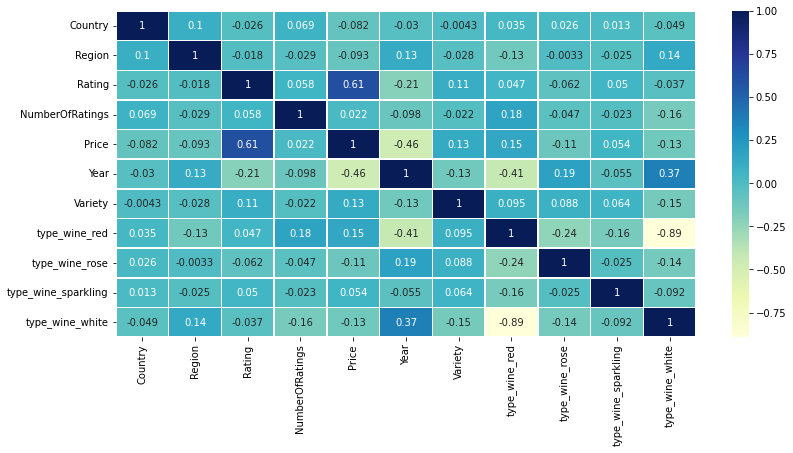

In [44]:
plt.figure(figsize=(13,6))
sns.heatmap(wine_no_anomalies.corr(), annot = True, linewidths=.6, cmap = 'YlGnBu')

**Split dataset**

In [45]:
# Разбивка с аномалиями
y = wine['Rating']
X = wine.drop(['Rating'], axis= 1)

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 234)

In [48]:
# Без аномалий
y_na = wine_no_anomalies['Rating']
X_na = wine_no_anomalies.drop(['Rating'], axis= 1)
X_na_train, X_na_test, y_na_train, y_na_test = train_test_split(X_na, y_na, test_size=.2, random_state = 1234)

**Linear Regression** 

Для дальнейшней работы с признаками посмотрим модель линейной регрессии, посмотрим что получится без нормализации признаков.

In [49]:
from sklearn.linear_model import LinearRegression

In [50]:
lm =LinearRegression()
lm.fit(X_train, y_train)
y_pred=lm.predict(X_train)

print(f"The R2 is: {round(r2_score(y_train, y_pred), 4)}")



The R2 is: 0.2681


 Очень низкий показатель, попробуем взять данные без аномалий.

In [51]:
lm1 =LinearRegression()
lm1.fit(X_na_train, y_na_train)

print(f"The R2 is {round(lm1.score(X_na_train, y_na_train), 4)}")

The R2 is 0.3883


Вывод: без аномалий линейная регрессия сработала немного лучше, но для такого разнообразия уникальных значений категориальных признаков она не подходит. Попробуем поставить другие параметры для нее.

**MinMax Scaler, Standart Scaler, Roboust Scaler**

Сделаем нормализацию и стандартизацию признаков, возьмем данные без аномалий.

In [52]:
# нормализация количественных признаков
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
scaled_minmax = minmax.fit_transform(X_na_train)
scaled_minmax_X_na_train = pd.DataFrame(scaled_minmax, columns = X_na_train.columns)
scaled_minmax_X_na_test = pd.DataFrame(scaled_minmax, columns = X_na_test.columns)
scaled_minmax_X_na_train.head()

# scaled_minmax = minmax.fit_transform(wine_no_anomalies)
# scaled_minmax_wine = pd.DataFrame(scaled_minmax, columns = wine_no_anomalies.columns)
# scaled_minmax_wine.head()

,Country,Region,NumberOfRatings,Price,Year,Variety,type_wine_red,type_wine_rose,type_wine_sparkling,type_wine_white
0,0.333333,0.684810,0.017808,0.968611,0.555556,1.000000,0.0,0.0,0.0,1.0
1,0.500000,0.939241,0.030137,0.121256,0.888889,1.000000,0.0,0.0,0.0,1.0
2,0.333333,0.192405,0.157534,0.228649,0.555556,1.000000,0.0,0.0,0.0,1.0
3,0.500000,0.253165,0.008219,0.244583,0.888889,0.312500,0.0,0.0,0.0,1.0
4,0.250000,0.187342,0.020548,0.047004,0.444444,0.850962,1.0,0.0,0.0,0.0


In [53]:
# Стандартизация
from sklearn.preprocessing import StandardScaler
standart = StandardScaler()
scaled_standart = standart.fit_transform(X_na_train)
scaled_standart_X_na_train = pd.DataFrame(scaled_standart, columns = X_na_train.columns)
scaled_standart_ = standart.fit_transform(X_test)
scaled_standart_X_na_test = pd.DataFrame(scaled_standart_, columns = X_na_test.columns)
scaled_standart_X_na_train.head()

# scaled_standart  = standart.fit_transform(wine_no_anomalies)
# scaled_standart_wine = pd.DataFrame(scaled_standart, columns = wine_no_anomalies.columns)
# scaled_standart_wine.head()

,Country,Region,NumberOfRatings,Price,Year,Variety,type_wine_red,type_wine_rose,type_wine_sparkling,type_wine_white
0,-0.723881,0.506429,-0.794660,3.396801,-0.197631,0.715208,-1.234153,-0.193764,-0.130512,1.382776
1,-0.044905,1.397118,-0.739350,-0.585977,1.409349,0.715208,-1.234153,-0.193764,-0.130512,1.382776
2,-0.723881,-1.217341,-0.167810,-0.081202,-0.197631,0.715208,-1.234153,-0.193764,-0.130512,1.382776
3,-0.044905,-1.004639,-0.837679,-0.006309,1.409349,-1.605272,-1.234153,-0.193764,-0.130512,1.382776
4,-1.063369,-1.235066,-0.782369,-0.934975,-0.733291,0.212167,0.810272,-0.193764,-0.130512,-0.723183


In [54]:
from sklearn.preprocessing import RobustScaler
robust = RobustScaler()
scaled_robust = robust.fit_transform(X_na_train)
scaled_robust_X_na_train = pd.DataFrame(scaled_robust, columns = X_na_train.columns)
scaled_robust = robust.fit_transform(X_test)
scaled_robust_X_na_test = pd.DataFrame(scaled_robust, columns = X_na_test.columns)
scaled_robust_X_na_train.head()

# robust_standart  = standart.fit_transform(wine_no_anomalies)
# robust_standart_wine = pd.DataFrame(robust_standart, columns = wine_no_anomalies.columns)
# robust_standart_wine.head()

,Country,Region,NumberOfRatings,Price,Year,Variety,type_wine_red,type_wine_rose,type_wine_sparkling,type_wine_white
0,-0.50,0.157360,-0.371429,3.417916,-0.333333,0.000000,-1.0,0.0,0.0,1.0
1,0.00,0.667513,-0.320000,-0.204700,0.666667,0.000000,-1.0,0.0,0.0,1.0
2,-0.50,-0.829949,0.211429,0.254428,-0.333333,0.000000,-1.0,0.0,0.0,1.0
3,0.00,-0.708122,-0.411429,0.322548,0.666667,-2.234375,-1.0,0.0,0.0,1.0
4,-0.75,-0.840102,-0.360000,-0.522139,-0.666667,-0.484375,0.0,0.0,0.0,0.0


Далее выбираем какая модель будет лучше

In [55]:
models_train = [X_na_train, scaled_minmax_X_na_train, scaled_standart_X_na_train, scaled_robust_X_na_train]
models_test = [X_na_test, scaled_minmax_X_na_test, scaled_standart_X_na_test, scaled_robust_X_na_test]


In [56]:
linregmodel = LinearRegression()

In [57]:
# Не обработанную модель делаю последней, чтобы было удобно задействовать в следующем исследовании
linregmodel.fit(models_train[1], y_na_train)    
print(f"The R2 of scaled_minmax training is {round(linregmodel.score(models_train[1], y_na_train), 6)}")
print("______________________________")

linregmodel.fit(models_train[2], y_na_train) 
print(f"The R2 of scaled_standart is {round(linregmodel.score(models_train[2], y_na_train), 6)}")
print("______________________________")

linregmodel.fit(models_train[3], y_na_train) 
print(f"The R2 scaled_robust is {round(linregmodel.score(models_train[3], y_na_train), 6)}")
print("______________________________")

linregmodel.fit(models_train[0], y_na_train)    
print(f"The R2 of LR is {round(linregmodel.score(models_train[0], y_na_train), 6)}")
print("______________________________")


The R2 of scaled_minmax training is 0.388301
______________________________
The R2 of scaled_standart is 0.388301
______________________________
The R2 scaled_robust is 0.388301
______________________________
The R2 of LR is 0.388301
______________________________


Выходит, что в данном случае стандартизация и нормализация не влияют на качество модели.

**RFECV**
(recursive feature elimination with cross validation)

In [58]:
from sklearn.feature_selection import RFECV

In [59]:
rfecv = RFECV(estimator=linregmodel, step=1, cv=8)

Optimal features is: 10


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Optimal features is: 9


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Optimal features is: 10


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Optimal features is: 9


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


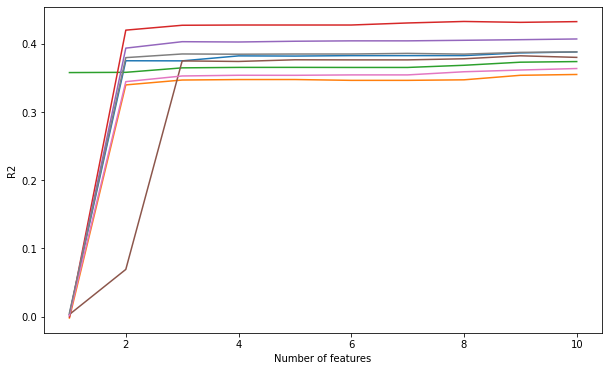

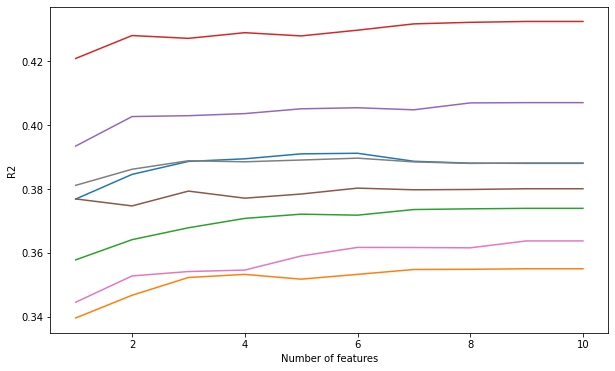

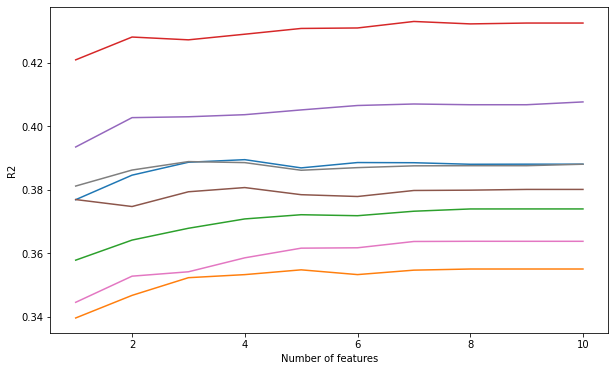

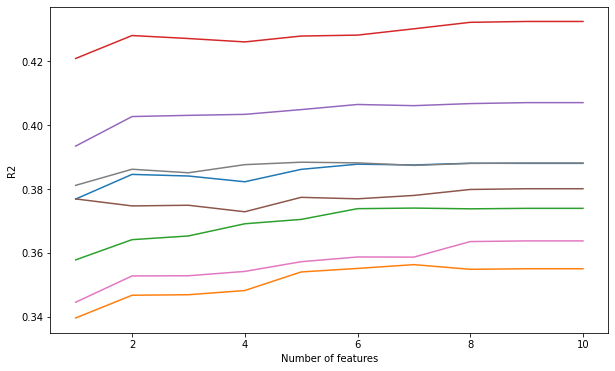

In [60]:
for i in models_train:
  rfecv.fit(i, y_na_train)
  print(f"Optimal features is: {rfecv.n_features_}")
  # построим 4 модели подряд графически
  plt.figure(figsize=(10, 6)) 
  plt.xlabel("Number of features") 
  plt.ylabel("R2") 
  plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_) 

Посмотрим какие признаки нам предлагает оставить rfecv

In [61]:
for i in models_train:
  rfecv.fit(i, y_na_train)
  rfecv.support_
  print(pd.DataFrame(rfecv.support_,index=X_na.columns,columns=['result']))

                     result
Country                True
Region                 True
NumberOfRatings        True
Price                  True
Year                   True
Variety                True
type_wine_red          True
type_wine_rose         True
type_wine_sparkling    True
type_wine_white        True
                     result
Country                True
Region                 True
NumberOfRatings        True
Price                  True
Year                   True
Variety                True
type_wine_red          True
type_wine_rose         True
type_wine_sparkling    True
type_wine_white       False
                     result
Country                True
Region                 True
NumberOfRatings        True
Price                  True
Year                   True
Variety                True
type_wine_red          True
type_wine_rose         True
type_wine_sparkling    True
type_wine_white        True
                     result
Country                True
Region              

In [62]:
#Нам предлагается убрать признак: белое вино. Оставляем признаки как есть
# Поэтому просто напишу код для тренировки моделей с выбранными с помощью  rfecv признаками  
# linregmodel_2 = LinearRegression()

# rfecv.fit(models_train[0], y_train)
# rfecv.support_
# X_train_new = models_train[0].loc[:, rfecv.support_]
# linregmodel_2.fit(X_train_new, y_train)
# X_test_new = models_test[0].loc[:,rfecv.support_]
# predicted = linregmodel_2.predict(X_test_new)

# print("Linear Regression: ")
# print(f"The R2 value training is {round(linregmodel_2.score(X_train_new, y_train), 4)}")
# print(f"The R2 value testing is {round(linregmodel_2.score(X_test_new, y_test), 4)}")
# print("______________________________________")

# Functions

In [63]:
# Для расчета датасета с аномалиями
# Фунция для расчета и вывода показателей моделей

def count_metrics(name_of_model):
  name_of_model.fit(X_train, y_train)
  y_pred = name_of_model.predict(X_test)
  crossr = cross_val_score(estimator = name_of_model, X = X_train, y = y_train, cv = 4,verbose = 0)
  mae = mean_absolute_error(y_test, y_pred)    
  mse = mean_squared_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred)**0.5
  rae = np.mean(abs(y_pred - y_test))/np.mean(abs(y_test-np.mean(y_test)))
  rse = np.mean((y_pred - y_test)**2)/np.mean((y_test-np.mean(y_test))**2)
  r2 = r2_score(y_test, y_pred)
  print(f"Results of {name_of_model}")
  print(f"The R2 value of {name_of_model} is {round(r2, 4)}")
  print(f"Mean Absolute Error is {round(mae, 6)}")
  print(f"Root Mean Squared Error is {round(rmse, 6)}")
  print(f"Relative Absolute Error is {round(rae, 6)}")
  print(f"Relative Squared Error is {round(rse, 6)}")
  print(f"Cross validation is {crossr}")
  print("*****")

# Функция для расчета и вывода значимости параметров
def params(name_of_model):
  param_df = pd.DataFrame({"Features": ['intercept'] + list(X.columns), 
  "Coef": [name_of_model.intercept_] + list(name_of_model.coef_)}) 
  cols = param_df.columns.tolist() 
  cols = cols[-1:]+cols[:-1] 
  param_df = param_df[cols] 
  print(param_df)

# Для расчета датасета без аномалий 
def count_metrics_na(name_of_model):
  name_of_model.fit(X_na_train, y_na_train)
  y_na_pred = name_of_model.predict(X_na_test)

  mae = mean_absolute_error(y_na_test, y_na_pred)    
  mse = mean_squared_error(y_na_test, y_na_pred)
  rmse = mean_squared_error(y_na_test, y_na_pred)**0.5
  rae = np.mean(abs(y_na_pred - y_na_test))/np.mean(abs(y_na_test-np.mean(y_na_test)))
  rse = np.mean((y_na_pred - y_na_test)**2)/np.mean((y_na_test-np.mean(y_na_test))**2)
  crossr = cross_val_score(estimator = name_of_model, X = X_na_train, y = y_na_train, cv = 4,verbose = 0)
  r2 = r2_score(y_na_test, y_na_pred)

  print(f"Results of {name_of_model}")
  print(f"The R2 value of {name_of_model} is {round(r2, 4)}")
  print(f"Mean Absolute Error is {round(mae, 6)}")
  print(f"Root Mean Squared Error is {round(rmse, 6)}")
  print(f"Relative Absolute Error is {round(rae, 6)}")
  print(f"Relative Squared Error is {round(rse, 6)}")
  print(f"Cross validation is {crossr}")
  print("*****")

# Функция для расчета и вывода значимости параметров
def params_na(name_of_model):
  param_df = pd.DataFrame({"Features": ['intercept'] + list(X_na.columns), 
  "Coef": [name_of_model.intercept_] + list(name_of_model.coef_)}) 
  cols = param_df.columns.tolist() 
  cols = cols[-1:]+cols[:-1] 
  param_df = param_df[cols] 
  print(param_df)

# Метрики
def metrics(name_of_model):
  mae = mean_absolute_error(y_test, y_pred)    
  mse = mean_squared_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred)**0.5
  rae = np.mean(abs(y_pred - y_test))/np.mean(abs(y_test-np.mean(y_test)))
  rse = np.mean((y_pred - y_test)**2)/np.mean((y_test-np.mean(y_test))**2)
  r2 = r2_score(y_test, y_pred)
  print(f"Results of {name_of_model}")
  print(f"The R2 value of {name_of_model} is {round(r2, 4)}")
  print(f"Mean Absolute Error is {round(mae, 6)}")
  print(f"Root Mean Squared Error is {round(rmse, 6)}")
  print(f"Relative Absolute Error is {round(rae, 6)}")
  print(f"Relative Squared Error is {round(rse, 6)}")
  print("*****")

# SKLearn Linear Regression

In [64]:
from sklearn.linear_model import Lasso, Ridge, ElasticNetCV
from sklearn import linear_model

Продолжим работать с очищенными от аномалий данными. Рассмотрим метрики линейной регрессии.


In [65]:
linregmodel =LinearRegression()
count_metrics_na(linregmodel)
params_na(linregmodel)

Results of LinearRegression()
The R2 value of LinearRegression() is 0.3847
Mean Absolute Error is 0.159457
Root Mean Squared Error is 0.201055
Relative Absolute Error is 0.780143
Relative Squared Error is 0.615269
Cross validation is [0.37225353 0.40543424 0.39329681 0.37768946]
*****
         Coef             Features
0  -20.207261            intercept
1    0.002248              Country
2    0.000034               Region
3    0.000089      NumberOfRatings
4    0.012537                Price
5    0.011764                 Year
6    0.000182              Variety
7   -0.011794        type_wine_red
8   -0.007995       type_wine_rose
9    0.015895  type_wine_sparkling
10   0.003894      type_wine_white


Посмотрим другие варианты линейной регрессии, возможно они дадут результат лучше

**Ridge**

In [66]:
ridgemodel = linear_model.Ridge(alpha=6, random_state=1234)
count_metrics_na(ridgemodel)
params_na(ridgemodel)

Results of Ridge(alpha=6, random_state=1234)
The R2 value of Ridge(alpha=6, random_state=1234) is 0.3847
Mean Absolute Error is 0.159462
Root Mean Squared Error is 0.201061
Relative Absolute Error is 0.780167
Relative Squared Error is 0.615301
Cross validation is [0.37227212 0.40543765 0.39329083 0.37769155]
*****
         Coef             Features
0  -20.192494            intercept
1    0.002248              Country
2    0.000034               Region
3    0.000089      NumberOfRatings
4    0.012537                Price
5    0.011757                 Year
6    0.000182              Variety
7   -0.011658        type_wine_red
8   -0.007700       type_wine_rose
9    0.015341  type_wine_sparkling
10   0.004017      type_wine_white


**Lasso**

In [67]:
lasso = linear_model.Lasso(alpha=0.001, random_state=1234)
count_metrics_na(lasso)
params_na(lasso)

Results of Lasso(alpha=0.001, random_state=1234)
The R2 value of Lasso(alpha=0.001, random_state=1234) is 0.3837
Mean Absolute Error is 0.159655
Root Mean Squared Error is 0.201221
Relative Absolute Error is 0.781111
Relative Squared Error is 0.616281
Cross validation is [0.3727174  0.40509965 0.3929551  0.37763102]
*****
         Coef             Features
0  -19.887789            intercept
1    0.002086              Country
2    0.000035               Region
3    0.000087      NumberOfRatings
4    0.012521                Price
5    0.011607                 Year
6    0.000177              Variety
7   -0.009918        type_wine_red
8   -0.000000       type_wine_rose
9    0.000000  type_wine_sparkling
10   0.001039      type_wine_white


**Elastic NET**

In [68]:
elastic = linear_model.ElasticNetCV()
count_metrics_na(elastic)
params_na(elastic)

Results of ElasticNetCV()
The R2 value of ElasticNetCV() is 0.3834
Mean Absolute Error is 0.159789
Root Mean Squared Error is 0.201274
Relative Absolute Error is 0.781765
Relative Squared Error is 0.616605
Cross validation is [0.37290189 0.40379727 0.39222976 0.37694675]
*****
         Coef             Features
0  -20.119968            intercept
1    0.001849              Country
2    0.000037               Region
3    0.000084      NumberOfRatings
4    0.012481                Price
5    0.011722                 Year
6    0.000172              Variety
7   -0.003445        type_wine_red
8   -0.000000       type_wine_rose
9    0.000000  type_wine_sparkling
10   0.000000      type_wine_white


Вывод: результат линейных моделей все равно очень низкий. Для такого датасета такая методика не подходит. Хотя метрика mae 0,16 для оценки от 0 до 5 достаточно хорошая, учитывая, что оценки выставляют до одного порядка после запятой.

#Random Forest Regression

In [69]:
from sklearn.ensemble import RandomForestRegressor

Сначала попробуем на датасете без аномалий

In [70]:
forestregmodel = RandomForestRegressor(n_estimators = 100, random_state = 1234, max_depth=8).fit(X_na_train, y_na_train)
count_metrics_na(forestregmodel)



Results of RandomForestRegressor(max_depth=8, random_state=1234)
The R2 value of RandomForestRegressor(max_depth=8, random_state=1234) is 0.4762
Mean Absolute Error is 0.145545
Root Mean Squared Error is 0.18551
Relative Absolute Error is 0.712078
Relative Squared Error is 0.523803
Cross validation is [0.46133144 0.49726446 0.46981611 0.46835846]
*****


In [71]:
# теперь с аномалиями
forestregmodel = RandomForestRegressor(n_estimators=200, random_state=1234, max_depth=10).fit(X_train, y_train)
count_metrics(forestregmodel)

Results of RandomForestRegressor(max_depth=10, n_estimators=200, random_state=1234)
The R2 value of RandomForestRegressor(max_depth=10, n_estimators=200, random_state=1234) is 0.6057
Mean Absolute Error is 0.143997
Root Mean Squared Error is 0.184702
Relative Absolute Error is 0.620125
Relative Squared Error is 0.394292
Cross validation is [0.60833535 0.61322689 0.6237513  0.58838659]
*****


Видим, что результаты получились лучше, чем на датасете без аномалий.

['3']


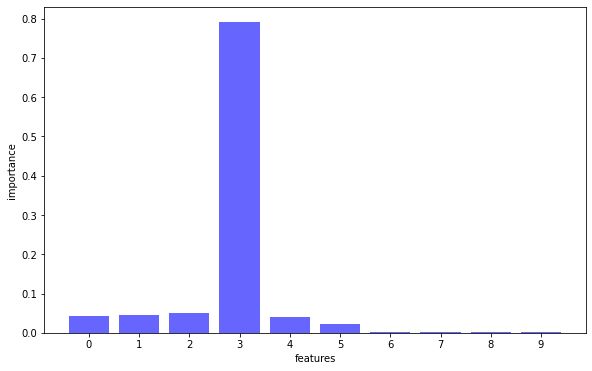

In [72]:
# Выбор важных признаков

important_features = []
for x,i in enumerate(forestregmodel.feature_importances_):
    if i>np.average(forestregmodel.feature_importances_):
        important_features.append(str(x))
print (important_features)


plt.figure(figsize=(6 * 1.618, 6))
feature_import=forestregmodel.feature_importances_
index = np.arange(len(feature_import))
plt.bar(index, feature_import, color='blue', alpha=0.6)
plt.xlabel('features')
plt.ylabel('importance')
plt.xticks(index)
plt.show()

Из признаков наиболее важный - цена. А меньше всего влияет тип вина.

# DecisionTreeRegressor

In [73]:
# На датасете с аномалиями
from sklearn.tree import DecisionTreeRegressor
dtreeregmodel = DecisionTreeRegressor(max_depth=7, random_state=1234).fit(X_train, y_train)
count_metrics(dtreeregmodel)

Results of DecisionTreeRegressor(max_depth=7, random_state=1234)
The R2 value of DecisionTreeRegressor(max_depth=7, random_state=1234) is 0.5573
Mean Absolute Error is 0.15227
Root Mean Squared Error is 0.19571
Relative Absolute Error is 0.655756
Relative Squared Error is 0.442692
Cross validation is [0.54959415 0.55944994 0.57519739 0.53664408]
*****


In [74]:
!pip install -q dtreeviz
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

     |████████████████████████████████| 62 kB 655 kB/s 


Посмотрим ведущие признаки

In [75]:
importances = dtreeregmodel.feature_importances_
feature_list = list(X_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

feature_results.head(10)

# Если делать на датасете без аномалий, то значение признака цена уменьшается, и при этом уменьшаются все метрики

,feature,importance
0,Price,0.903692
1,Country,0.034440
2,Year,0.022391
3,Region,0.019724
4,NumberOfRatings,0.010752
5,Variety,0.007888
6,type_wine_sparkling,0.000515
7,type_wine_white,0.000353
8,type_wine_red,0.000243
9,type_wine_rose,0.000000


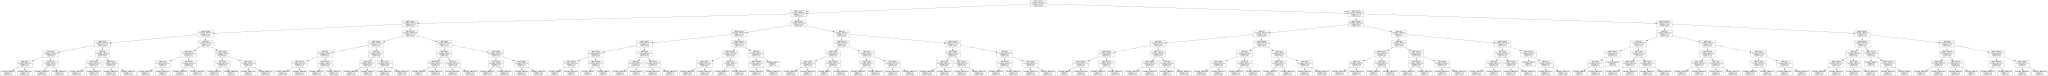

In [76]:
tree = tree.export_graphviz(dtreeregmodel)
graph = graphviz.Source(tree)  
graph 

# Gradient Boosting Machines

**SGD**

In [77]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline

In [78]:
# На датасете без аномалий, так как мы видели что в RF он показал себя намного лучше
SGD = SGDRegressor(alpha=0.0001, l1_ratio=0.2, random_state=1234, eta0=0.01, power_t=0.2, validation_fraction=0.05).fit(X_na_train, y_na_train)

In [79]:
# приведение данных к нормальному закону расределения: 
#стандартизация признаков, вычитая среднее значение и масштабируя до единичной дисперсии z = (x-u)/s
SGD_StandardScaler = make_pipeline(StandardScaler(), SGDRegressor(max_iter=50, tol=1e-3))

count_metrics_na(SGD_StandardScaler)

Results of Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor(max_iter=50))])
The R2 value of Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor(max_iter=50))]) is 0.3815
Mean Absolute Error is 0.159889
Root Mean Squared Error is 0.201576
Relative Absolute Error is 0.782255
Relative Squared Error is 0.618461
Cross validation is [0.36916174 0.40341116 0.39282243 0.37812331]
*****


Результаты на датасете с аномалиями выше, хотя по прежнему r2 низкий

**K-Neighbors Regressor**

In [80]:
from sklearn.neighbors import KNeighborsRegressor
k_near = KNeighborsRegressor(n_neighbors = 13)
count_metrics(k_near)

Results of KNeighborsRegressor(n_neighbors=13)
The R2 value of KNeighborsRegressor(n_neighbors=13) is 0.3783
Mean Absolute Error is 0.183142
Root Mean Squared Error is 0.231927
Relative Absolute Error is 0.788705
Relative Squared Error is 0.621695
Cross validation is [0.382322   0.3926554  0.40212295 0.35650823]
*****


**GradientBoostingRegressor**

In [81]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [82]:
gb_reg = GradientBoostingRegressor(n_estimators=100, random_state=1234, learning_rate= 0.3)
hist_gb_reg = HistGradientBoostingRegressor(max_iter=80, max_depth=8, random_state=1234)
count_metrics(gb_reg)
print("_____________________________________________")
count_metrics(hist_gb_reg)
print("_____________________________________________")


Results of GradientBoostingRegressor(learning_rate=0.3, random_state=1234)
The R2 value of GradientBoostingRegressor(learning_rate=0.3, random_state=1234) is 0.6229
Mean Absolute Error is 0.139945
Root Mean Squared Error is 0.180627
Relative Absolute Error is 0.602677
Relative Squared Error is 0.377086
Cross validation is [0.62377909 0.62762102 0.64276011 0.60691823]
*****
_____________________________________________
Results of HistGradientBoostingRegressor(max_depth=8, max_iter=80, random_state=1234)
The R2 value of HistGradientBoostingRegressor(max_depth=8, max_iter=80, random_state=1234) is 0.6203
Mean Absolute Error is 0.14079
Root Mean Squared Error is 0.181246
Relative Absolute Error is 0.606316
Relative Squared Error is 0.379676
Cross validation is [0.62605347 0.63156365 0.6436532  0.60354961]
*****
_____________________________________________


#Light GBM

In [83]:
!pip install lightgbm
import lightgbm as lgb
from lightgbm.sklearn import LGBMRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [84]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=1234)

In [85]:
lgb_train = lgb.Dataset(X_train,y_train)
lgb_test = lgb.Dataset(X_test,y_test, reference=lgb_train)

params = {'boosting_type': 'gbdt', 'objective': 'regression',
    'metric': {'l2', 'l1'}, 'num_leaves': 25, 'learning_rate': 0.05,
    'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'verbose': 0}

gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_test, early_stopping_rounds=5)
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

[1]	valid_0's l2: 0.0818338	valid_0's l1: 0.226052
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.0775243	valid_0's l1: 0.2199
[3]	valid_0's l2: 0.0735925	valid_0's l1: 0.214104
[4]	valid_0's l2: 0.0700329	valid_0's l1: 0.208756
[5]	valid_0's l2: 0.0668361	valid_0's l1: 0.203771
[6]	valid_0's l2: 0.0638978	valid_0's l1: 0.199111
[7]	valid_0's l2: 0.0612333	valid_0's l1: 0.194824
[8]	valid_0's l2: 0.0603777	valid_0's l1: 0.193409
[9]	valid_0's l2: 0.0580547	valid_0's l1: 0.189528
[10]	valid_0's l2: 0.0559301	valid_0's l1: 0.185925
[11]	valid_0's l2: 0.0540255	valid_0's l1: 0.182721
[12]	valid_0's l2: 0.052322	valid_0's l1: 0.179774
[13]	valid_0's l2: 0.0507277	valid_0's l1: 0.177021
[14]	valid_0's l2: 0.0493477	valid_0's l1: 0.174545
[15]	valid_0's l2: 0.0479863	valid_0's l1: 0.172083
[16]	valid_0's l2: 0.0468062	valid_0's l1: 0.169905
[17]	valid_0's l2: 0.0457308	valid_0's l1: 0.167906
[18]	valid_0's l2: 0.0447683	valid_0's l1: 0.166086
[19]	valid_0's 

In [86]:
metrics(gbm)

Results of <lightgbm.basic.Booster object at 0x7f65c4adfb10>
The R2 value of <lightgbm.basic.Booster object at 0x7f65c4adfb10> is 0.6431
Mean Absolute Error is 0.137614
Root Mean Squared Error is 0.175732
Relative Absolute Error is 0.592637
Relative Squared Error is 0.356924
*****


In [87]:
# Для проверки не переобучилась ли модель
print(f"The R-squared train value is: {r2_score(y_train,gbm.predict(X_train))}") 

The R-squared train value is: 0.6617157927883457


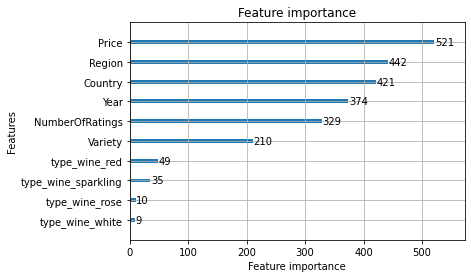

In [88]:
ax = lgb.plot_importance(gbm, max_num_features=10)
plt.rcParams['figure.figsize'] = [5, 3]
plt.show()

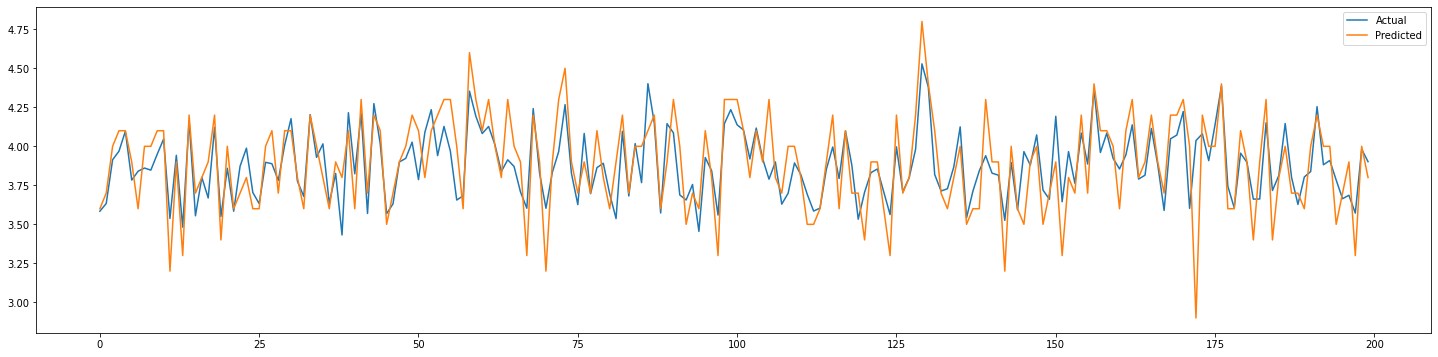

In [89]:
test = pd.DataFrame({'Predicted':y_pred,'Actual':y_test})
fig= plt.figure(figsize=(25,6))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:200])
plt.legend(['Actual','Predicted'])

# XGBRegressor

In [90]:
!pip install xgboost
import xgboost as xgb
from xgboost import XGBRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
xgbr = XGBRegressor(n_estimators=250, learning_rate=0.8, random_state=1234)
count_metrics(xgbr)

[14:09:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:09:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:09:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:09:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:09:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Results of XGBRegressor(learning_rate=0.8, n_estimators=250, random_state=1234)
The R2 value of XGBRegressor(learning_rate=0.8, n_estimators=250, random_state=1234) is 0.7231
Mean Absolute Error is 0.119393
Root Mean Squared Error is 0.154793
Relative Absolute Error is 0.51417
Relative Squared Error is 0.276934
Cross validation is [0.58008094 0.59343804 0.5500671

In [92]:
print(f"The R-squared train value is: {round(r2_score(y_train,xgbr.predict(X_train)), 4)}")

The R-squared train value is: 0.7731


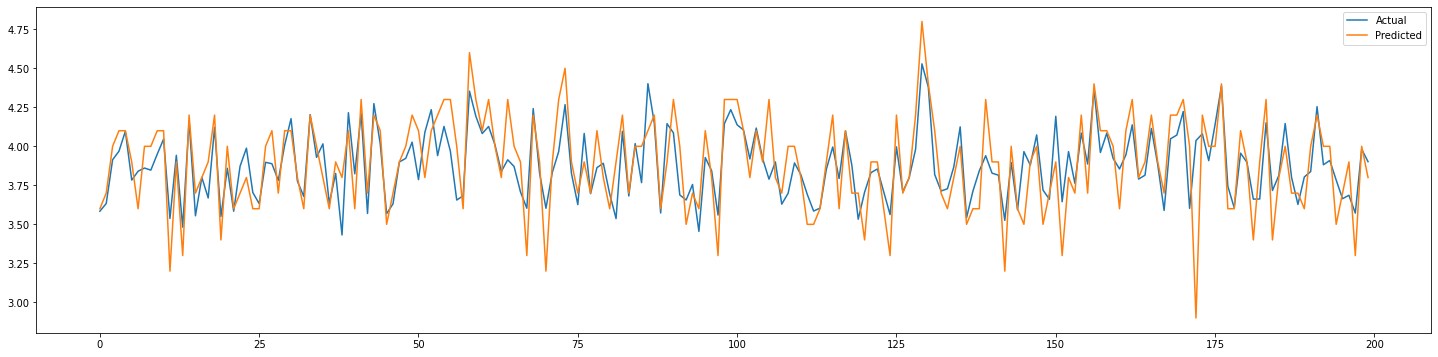

In [93]:
test = pd.DataFrame({'Predicted':y_pred,'Actual':y_test})
fig= plt.figure(figsize=(25,6))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:200])
plt.legend(['Actual','Predicted'])

Данная модель получилась с лучшим результатом, чем предыдущие.

# XGBoost

In [94]:
dataxgb = xgb.DMatrix(data=X,label=y)

In [95]:
xgboost = xgb.XGBRegressor(colsample_bytree = 0.9, learning_rate = 0.5, max_depth = 5, alpha = 10, n_estimators = 200)

In [96]:
xgboost.fit(X_train,y_train)

[14:09:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, colsample_bytree=0.9, learning_rate=0.5, max_depth=5,
             n_estimators=200)

In [97]:
print(f"The R-squared train value is: {round(r2_score(y_train,xgboost.predict(X_train)), 4)}")

The R-squared train value is: 0.867


In [98]:
y_pred = xgboost.predict(X_test)

In [99]:
metrics(xgboost)

Results of XGBRegressor(alpha=10, colsample_bytree=0.9, learning_rate=0.5, max_depth=5,
             n_estimators=200)
The R2 value of XGBRegressor(alpha=10, colsample_bytree=0.9, learning_rate=0.5, max_depth=5,
             n_estimators=200) is 0.8061
Mean Absolute Error is 0.095879
Root Mean Squared Error is 0.129528
Relative Absolute Error is 0.412904
Relative Squared Error is 0.19391
*****


In [100]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

In [101]:
cv_results = xgb.cv(dtrain=dataxgb, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=1234)

[14:09:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:09:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:09:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:09:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:09:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [102]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,3.042705,0.000622,3.042724,0.002549
1,2.741342,0.000577,2.741371,0.002567
2,2.470044,0.000998,2.469923,0.002003
3,2.226202,0.000928,2.226163,0.002145
4,2.006600,0.000768,2.006539,0.002214


In [103]:
from google.colab import output
output.enable_custom_widget_manager()

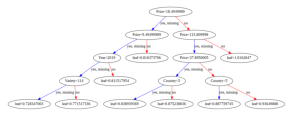

In [104]:
xgb.plot_tree(xgboost,num_trees=1)
plt.rcParams['figure.figsize'] = (100, 100)
plt.show()

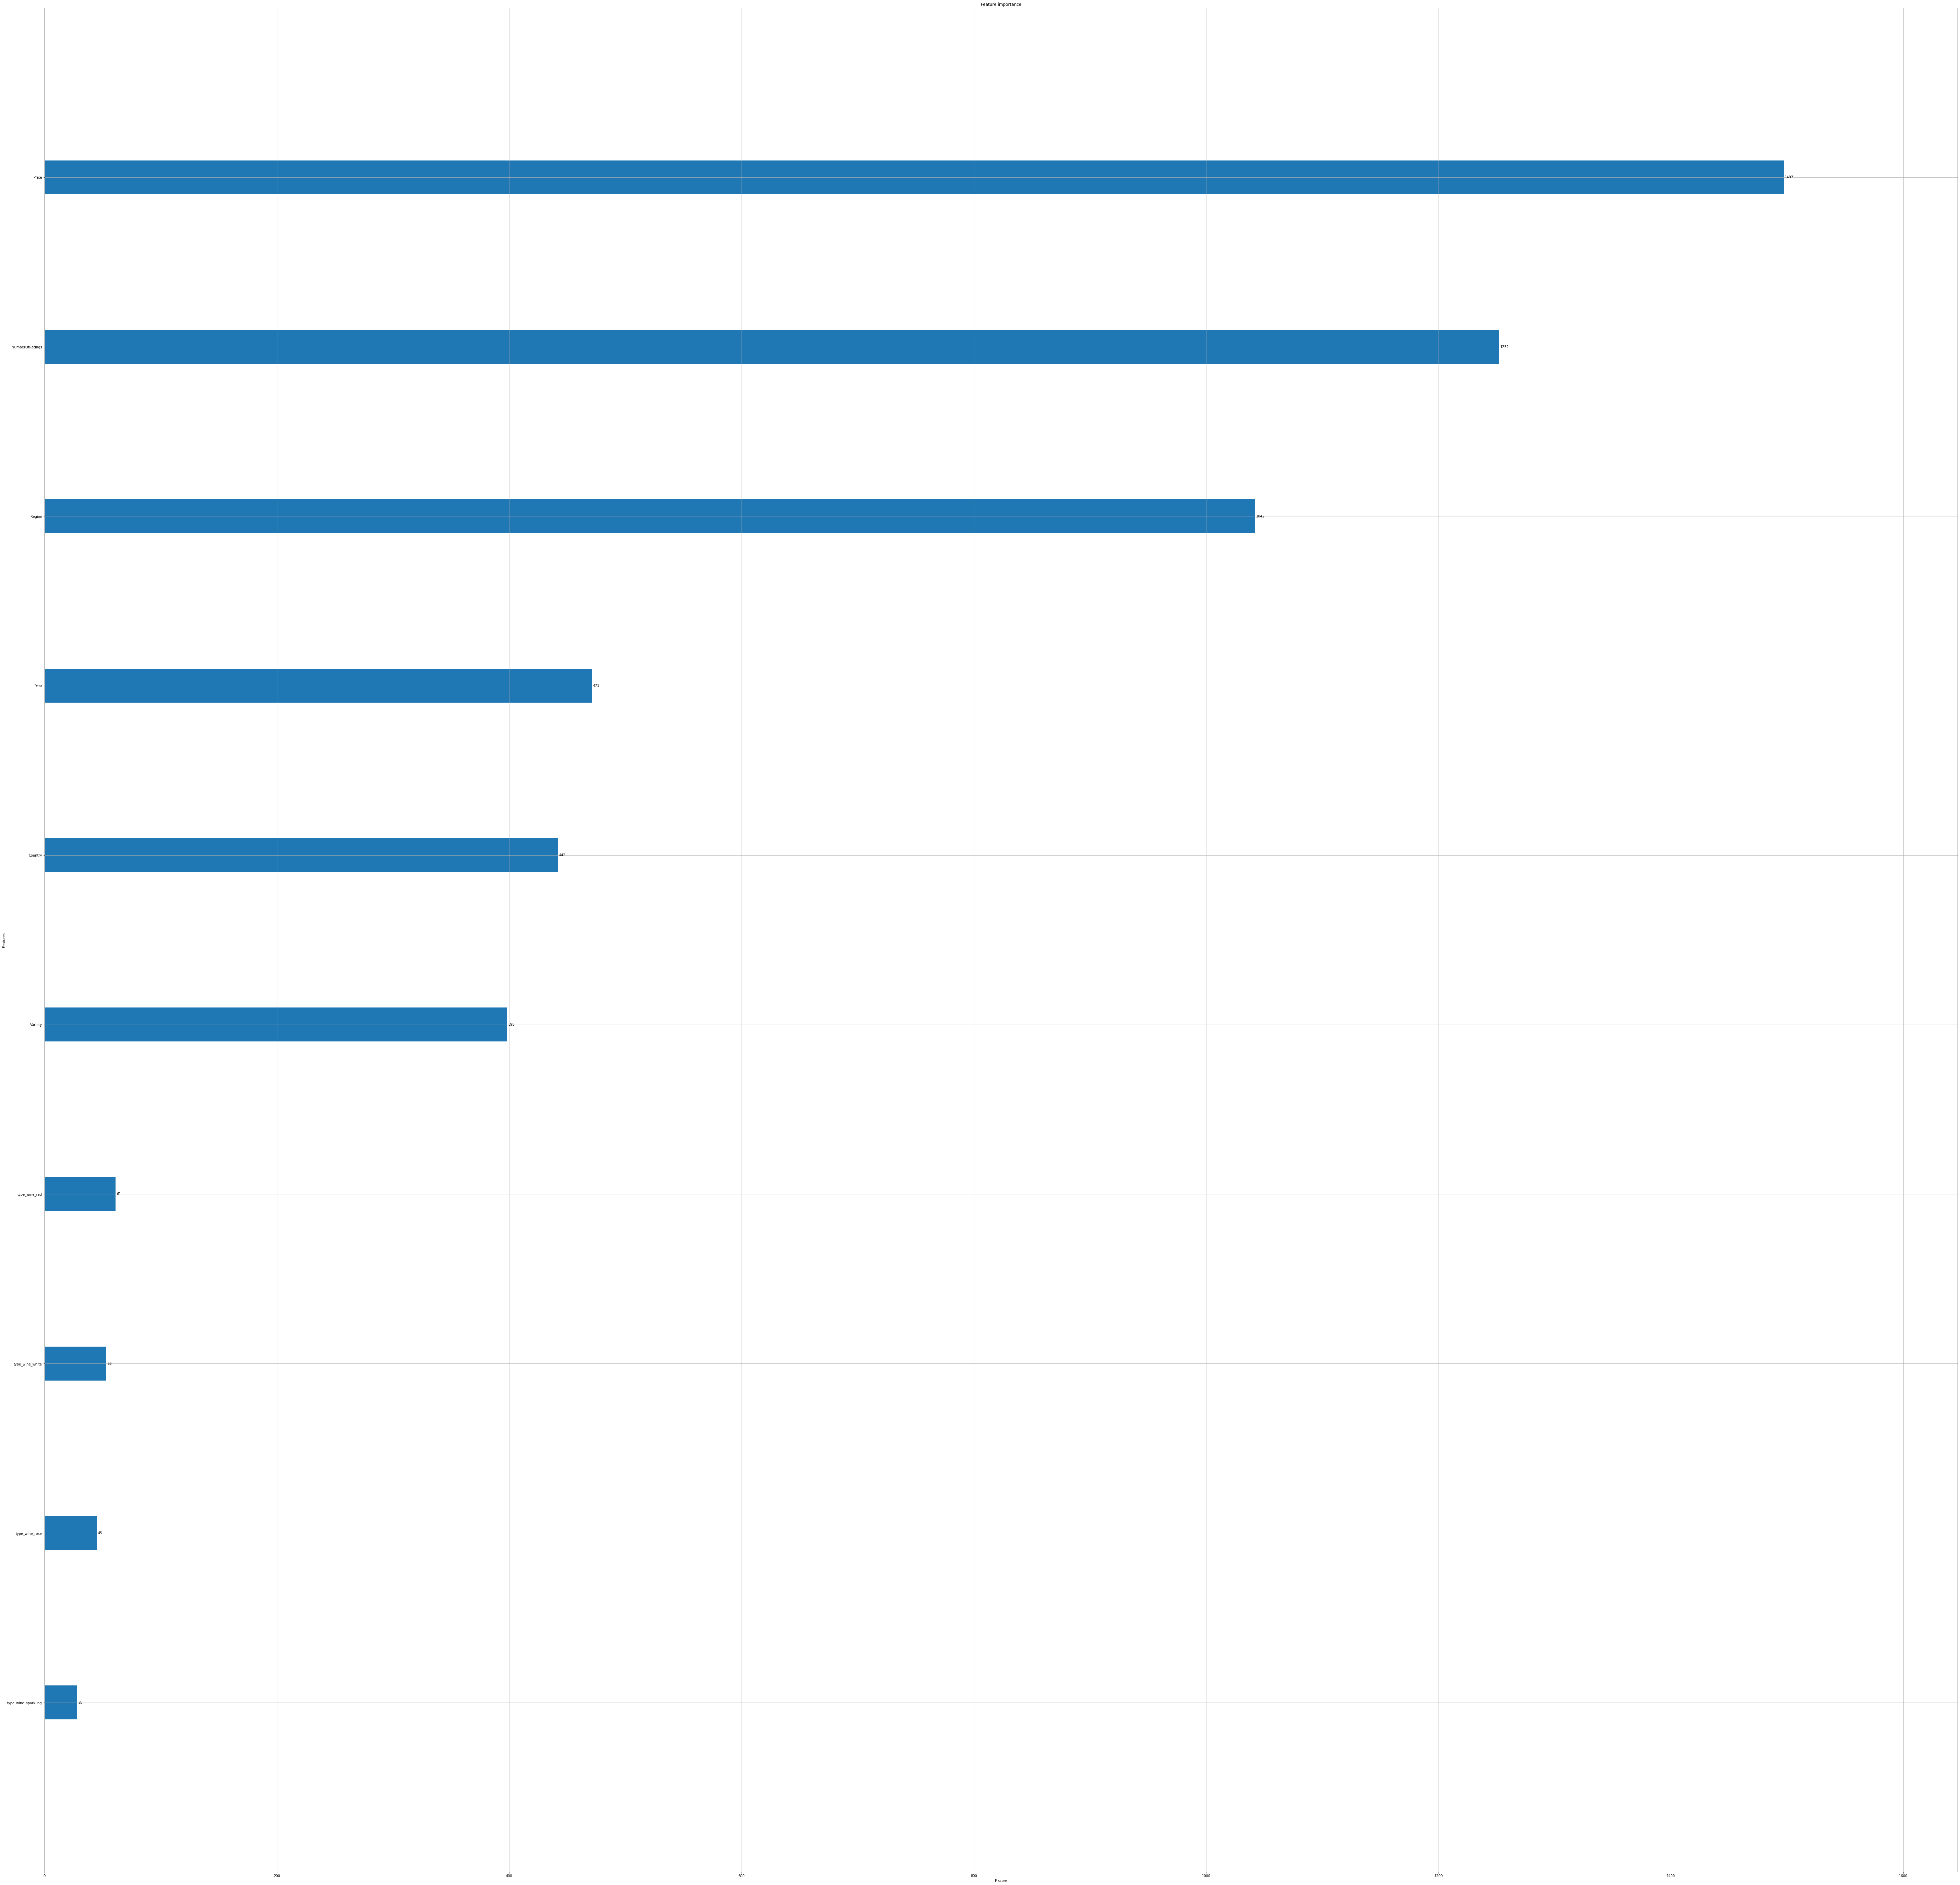

In [105]:
xgb.plot_importance(xgboost)
plt.rcParams['figure.figsize'] = [5, 3]
plt.show()

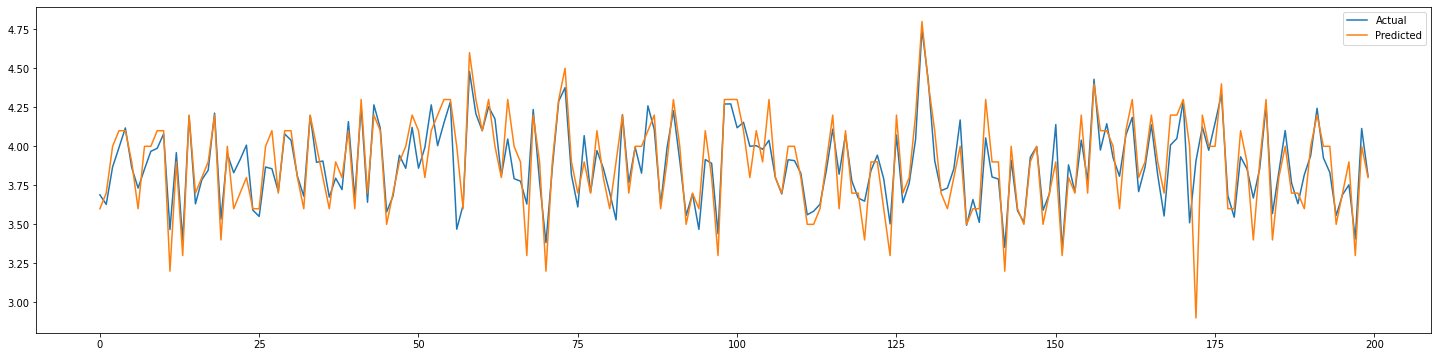

In [106]:
test = pd.DataFrame({'Predicted':y_pred,'Actual':y_test})
fig= plt.figure(figsize=(25,6))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:200])
plt.legend(['Actual','Predicted'])

Данная модель показала себя еще лучше, mae снизился до менее 0,1

#Cat Boost

In [107]:
!pip install catboost
from catboost import CatBoostRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 14 kB/s 


In [108]:
catreg=CatBoostRegressor(iterations=500, depth=5, learning_rate=0.2, loss_function='MAE')
catreg.fit(X_train, y_train,eval_set=(X_test, y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2144089	test: 0.2127275	best: 0.2127275 (0)	total: 54.9ms	remaining: 27.4s
1:	learn: 0.1978880	test: 0.1971092	best: 0.1971092 (1)	total: 70.3ms	remaining: 17.5s
2:	learn: 0.1863640	test: 0.1860384	best: 0.1860384 (2)	total: 98.3ms	remaining: 16.3s
3:	learn: 0.1777538	test: 0.1775297	best: 0.1775297 (3)	total: 111ms	remaining: 13.8s
4:	learn: 0.1715864	test: 0.1714439	best: 0.1714439 (4)	total: 133ms	remaining: 13.2s
5:	learn: 0.1667584	test: 0.1668249	best: 0.1668249 (5)	total: 149ms	remaining: 12.3s
6:	learn: 0.1623707	test: 0.1625165	best: 0.1625165 (6)	total: 163ms	remaining: 11.5s
7:	learn: 0.1588563	test: 0.1588088	best: 0.1588088 (7)	total: 178ms	remaining: 11s
8:	learn: 0.1564099	test: 0.1563163	best: 0.1563163 (8)	total: 193ms	remaining: 10.5s
9:	learn: 0.1544760	test: 0.1543410	best: 0.1543410 (9)	total: 209ms	remaining: 10.2s
10:	learn: 0.1530626	test: 0.1529630	best: 0.1529630 (10)	total: 223ms	remaining: 9.91s
11:	learn: 0.1522040	test: 0.1521444	best: 0.152144

In [109]:
print(f"The R-squared train value is {r2_score(y_train,catreg.predict(X_train))}")

The R-squared train value is 0.7011094907676041


In [110]:
y_pred = catreg.predict(X_test)
metrics(catreg)

Results of <catboost.core.CatBoostRegressor object at 0x7f65afdf6f50>
The R2 value of <catboost.core.CatBoostRegressor object at 0x7f65afdf6f50> is 0.6779
Mean Absolute Error is 0.124948
Root Mean Squared Error is 0.166938
Relative Absolute Error is 0.53809
Relative Squared Error is 0.322094
*****


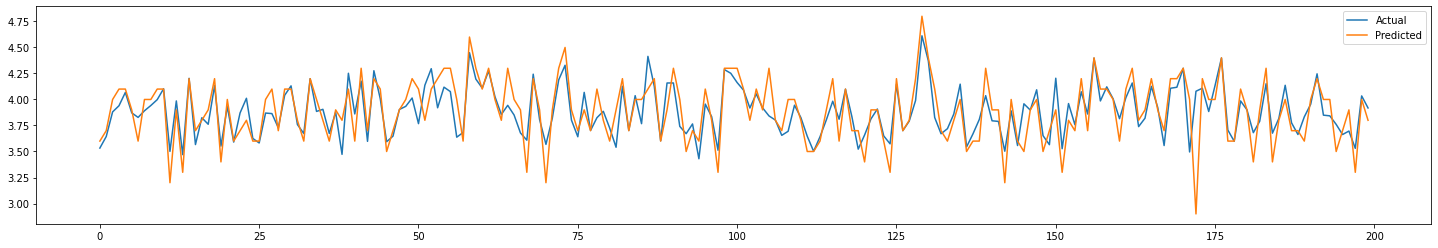

In [111]:
test = pd.DataFrame({'Predicted':y_pred,'Actual':y_test})
fig= plt.figure(figsize=(25,4))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:200])
plt.legend(['Actual','Predicted'])

**Cat Boost with categorical features**

In [112]:
X = wine_for_autoML.drop(['Rating'], axis=1)
y = wine_for_autoML.Rating
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.2, random_state=1234)

In [113]:
cat_feat = np.where(X.dtypes != np.float)[0]
# не числа

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [114]:
from catboost import CatBoostRegressor
catregcat=CatBoostRegressor(iterations=500, depth=4, learning_rate=0.1, loss_function='MAE')

In [115]:
catregcat.fit(X_train, y_train,cat_features=cat_feat,eval_set=(X_test, y_test), plot= True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2260437	test: 0.2258427	best: 0.2258427 (0)	total: 11.4ms	remaining: 5.68s
1:	learn: 0.2188694	test: 0.2190263	best: 0.2190263 (1)	total: 17.8ms	remaining: 4.43s
2:	learn: 0.2112385	test: 0.2111306	best: 0.2111306 (2)	total: 22.8ms	remaining: 3.77s
3:	learn: 0.2032495	test: 0.2038896	best: 0.2038896 (3)	total: 28.1ms	remaining: 3.49s
4:	learn: 0.1969301	test: 0.1985108	best: 0.1985108 (4)	total: 33.9ms	remaining: 3.36s
5:	learn: 0.1916398	test: 0.1934592	best: 0.1934592 (5)	total: 39ms	remaining: 3.21s
6:	learn: 0.1859657	test: 0.1886929	best: 0.1886929 (6)	total: 44ms	remaining: 3.1s
7:	learn: 0.1808800	test: 0.1839528	best: 0.1839528 (7)	total: 49.6ms	remaining: 3.05s
8:	learn: 0.1768273	test: 0.1796065	best: 0.1796065 (8)	total: 54.5ms	remaining: 2.98s
9:	learn: 0.1737625	test: 0.1806999	best: 0.1796065 (8)	total: 60.8ms	remaining: 2.98s
10:	learn: 0.1708743	test: 0.1782793	best: 0.1782793 (10)	total: 64.9ms	remaining: 2.89s
11:	learn: 0.1689690	test: 0.1761942	best: 0.1

In [116]:
y_pred = catregcat.predict(X_test)

In [117]:
print(f"The R-squared train value is {r2_score(y_train,catregcat.predict(X_train))}")

The R-squared train value is 0.6001326704138115


In [118]:
metrics(catregcat)

Results of <catboost.core.CatBoostRegressor object at 0x7f65af138390>
The R2 value of <catboost.core.CatBoostRegressor object at 0x7f65af138390> is 0.533
Mean Absolute Error is 0.15663
Root Mean Squared Error is 0.201018
Relative Absolute Error is 0.674529
Relative Squared Error is 0.467028
*****


# Resume

В данной работе:

1. Выбран датасет согласно моей специализации
2. Проведен EDA
3. Проведена работа с признаками, категориальные переведены в числовые.
4. Подготовлены и обучены модели в следующих библиотеках:

Лучшие показатели по R2:

* в Scikit-learn Gradient Boosting Regressor: 62,03%
* XGBRegressor: 72,31%
* LightGBM: 64,31%
* Cat Boost: 67,79%
* XGBoost: 80,61%

В результате работы определено, что модели линейной регрессии не подходят для работы с таким количеством уникальных значений и с такой низкой корреляцией признаков.
Более сложные модели показали лучшие результаты на данных, не очищенных от выбросов. Полагаю, что причина в том, что таких данных было менее 2% от датасета.
PyCaret, AutoGluon в отдельном блокноте - так как берут много памяти и требуют перезагрузки.